# CSCI E-25      
## Homography and Projection 
### Steve Elston

## Introduction   

Transformation or projection of images is a fundamental and essential method in computer vision. Many applications, such as image stitching and stereo vision, require projection methods. 

In these exercises our primary focus is on projection using the extrinsic matrix. You will apply three types of commonly used extrinsic and one intrinsic transformation to an image:    
1. **Euclidean**, rotation and translation. 
2. **Similarity**, rotation, translation and scale.
3. **Affine**,  rotation, translation, scale and shear. 
4. **Intrinsic camera parameters**, focal length. 

Before starting the exercises execute the code in the cell below to import the required packages. 

In [26]:
import skimage 
from skimage import data
from skimage.filters.rank import equalize
import skimage.filters as skfilters
import skimage.morphology as morphology
import skimage.transform as transform
from skimage.color import rgb2gray
from skimage import exposure
from PIL import Image
import numpy as np
import math
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Prepare the Image 

For these exercises you will work with a gray scale image. Execute the code in the cell below to load the image and display it. 

Image size = (512, 512)


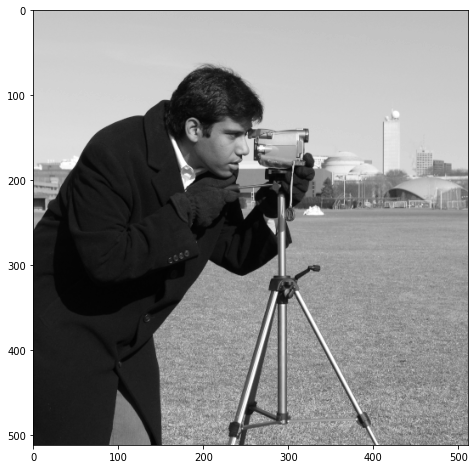

In [3]:
def plot_grayscale(img, h=8):
    plt.figure(figsize=(h, h))
    _=plt.imshow(img, cmap=plt.get_cmap('gray'))

camera_image = data.camera() 
print('Image size = ' + str(camera_image.shape))
plot_grayscale(camera_image)

To make the process of visualizing the transformations of image easier a dark margin will be added to the image. Execute the code in the cell below to place the image on the background and to display the result.   

Shape of the background = (1024, 1024)


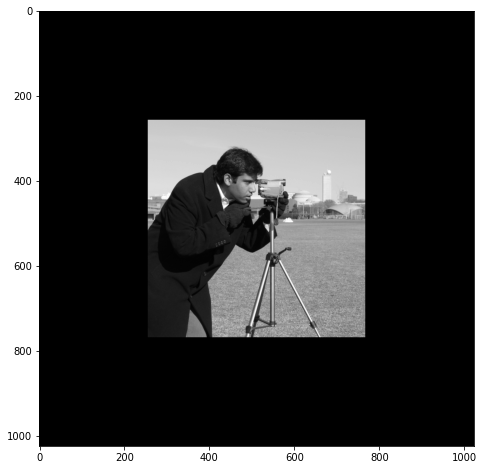

In [4]:
half_margin = 256
background = np.zeros((camera_image.shape[0] + 2*half_margin, camera_image.shape[1] + 2*half_margin)).astype('int')
print('Shape of the background = ' + str(background.shape))

camera_image_background = background
#camera_image_background[2*half_margin:camera_image_background.shape[0], 0:camera_image_background.shape[1]-2*half_margin] = camera_image
camera_image_background[half_margin:camera_image_background.shape[0] - half_margin, half_margin:camera_image_background.shape[1]-half_margin] = camera_image
plot_grayscale(camera_image_background)

> **Note:** Unless otherwise specified, use this gray scale image for the following exercises. 

## Euclidean Transformation

The Euclidean transformation involves only rotation and translation. The shape of objects is preserved by the Euclidean transformation.     

> **Exercise 8-1:** You will now apply the Euclidean transformation to the image with the margin background. Perform the following steps:   
> 1. Create the Numpy transformation matrix for a rotation of $\pi/8$, with no translation, in homogeneous coordinates.   
> 2. Display the transformation matrix.  
> 3. Apply your transformation matrix to the image using the [skimage.transform.warp](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp) function, and display the result.

[[ 0.92387953 -0.38268343  0.        ]
 [ 0.38268343  0.92387953  0.        ]
 [ 0.          0.          1.        ]]


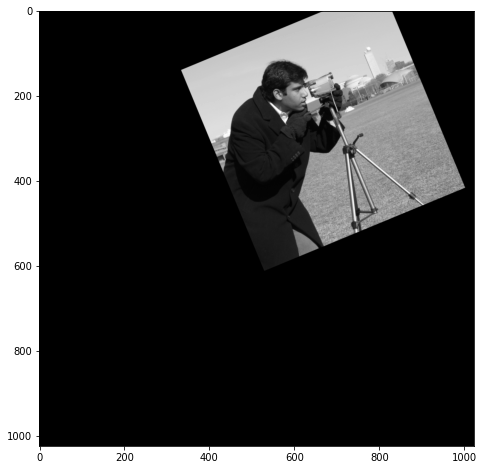

In [28]:
theta = np.pi / 8

def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

print(rotation_matrix(theta))

plot_grayscale(skimage.transform.warp(camera_image_background, rotation_matrix(theta)))

> 4. Next create a new Numpy transformation matrix in homogeneous coordinates with the same rotation of $\pi/8$, but with a translation vector of of $[256, -128]^T$. 
> 5. Display the new transformation matrix.   
> 6. Apply your transformation matrix to the image and display the result.  

[[   0.92387953   -0.38268343  256.        ]
 [   0.38268343    0.92387953 -128.        ]
 [   0.            0.            1.        ]]


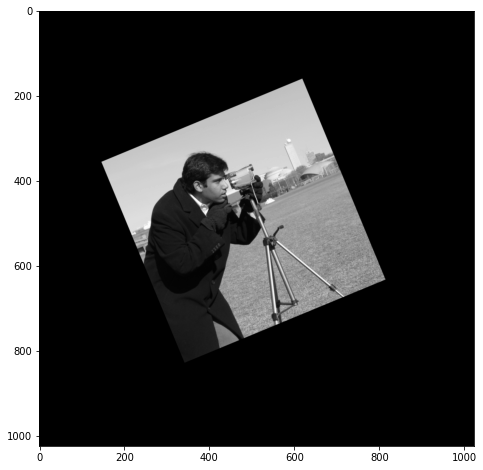

In [29]:
def homogeneous_matrix(theta: float, translation: List[int]):
    return np.array([
        [np.cos(theta), -np.sin(theta), translation[0]],
        [np.sin(theta), np.cos(theta), translation[1]],
        [0, 0, 1]
    ])

print(homogeneous_matrix(theta=np.pi/8, translation=np.array([256, -128])))
plot_grayscale(skimage.transform.warp(camera_image_background, homogeneous_matrix(theta=np.pi/8, translation=np.array([256, -128]))))

> 7. Finally, you can check your transformation matrix by using the [skimage.transform.EuclideanTransform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.EuclideanTransform) function, using the rotation angle and translation vector. Compute and display the transformation matrix, in homogeneous coordinates, using the arguments specified in step 4 of this exercise.   

In [31]:
skimage.transform.EuclideanTransform(rotation=np.pi/8, translation=[256, -128])

<EuclideanTransform(matrix=
    [[   0.92387953,   -0.38268343,  256.        ],
     [   0.38268343,    0.92387953, -128.        ],
     [   0.        ,    0.        ,    1.        ]]) at 0x7f263b357190>

> In one or two sentences answer the following questions:   
> 1. Examine the image displayed in step 3. Keeping in mind that the origin of the image display is in the upper left corner, does the rotated image appear as you expected and why?  
> 2. How does the addition of a translation change the result of the transformation.   
> 3. Compare the transformation matrix you computed for step 4 with the matrix computed in step 7. Are these transformation matrices the same?  
> **End of exercise.**

> **Answers:** 
> 1. Yes, because we are rotating with the origin being the top-left corner of the image with the additional borders. The entire image is rotated by pi/8.
> 2. The rotated image is then translated towards the bottom left, which results in the image being closer to the center, compared to the simple rotation.
> 3. Yes, they are the same.

## Similarity Transform

You will now extend the generality of the transformation by adding a change of scale. A similarity transformation can perform rotation, translation as scale. The like the Euclidean transform, the similarity transform preserves shape.   

> **Exercise 8-2:**  You will now do the following to explore the properties of the similarity transform: 
> 1. Create a NHumpy transformation matrix in homogeneous coordinates with the same rotation of $\pi/8$, translation vector of of $[128,0]^T$ and a scale of 0.5. Keep in mind that the scale is applied as $1.0/scale$ to each of the rotation matrix elements. 
> 2. Display the transformation matrix.   
> 3. Apply your transformation matrix to the image and display the result.  

[[  1.84775907  -0.76536686 128.        ]
 [  0.76536686   1.84775907   0.        ]
 [  0.           0.           1.        ]]


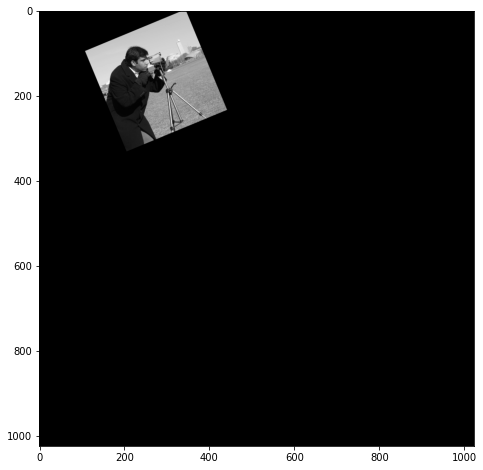

In [42]:
def homogeneous_matrix(theta: float = 0, translation: List[int] = [0, 0], scale: float = 1.0):
    return np.array([
        [np.cos(theta) / scale, -np.sin(theta) / scale, translation[0]],
        [np.sin(theta) / scale, np.cos(theta) / scale, translation[1]],
        [0, 0, 1]
    ])

print(homogeneous_matrix(theta=np.pi/8, translation=np.array([128, 0]), scale=0.5))

plot_grayscale(skimage.transform.warp(camera_image_background, homogeneous_matrix(theta=np.pi/8, translation=np.array([128, 0]), scale=0.5)))

> 4. You can check your transformation matrix by using the [skimage.transform.SimilarityTransform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.SimilarityTransform) function, using the rotation angle, translation vector and scale (using the inverse). Compute and display the transformation matrix, in homogeneous coordinates, using the arguments specified in step 1 of this exercise.

In [45]:
skimage.transform.SimilarityTransform(rotation=np.pi/8, translation=[128, 0], scale=1/0.5)

<SimilarityTransform(matrix=
    [[  1.84775907,  -0.76536686, 128.        ],
     [  0.76536686,   1.84775907,   0.        ],
     [  0.        ,   0.        ,   1.        ]]) at 0x7f263b06e2b0>

> In one or two sentences answer the following questions. 
> 1. Compare the image size and shape against the original image size. Does the transform appear to be correctly applied and why?   
> 2. Is the homogeneous transformation matrix you computed identical to the one computed with the `SimilarityTransform` function? 
> **End of exercise.**

> **Answer:** 
> 1. Yes, we can see that the image is rotated in the same direction as in the initial transformation. It is also translated along the x-axis and scaled by a factor of 0.5.
> 2. Yes, with the exception that the scale argument expects the inverse and does not compute $\rho = 1 / scale$, but instead expects $\rho = scale$

## Affine Transform

Continuing to generalize the transformation you will now add a shear factor to the transformation. An affine transformation can perform rotation, translation, scaling and shear. The affine transformation preserves parallel lines.   

> **Exercise 8-3:**  You will now do the following to explore the properties of the affine transform: 
> 1. Create a Numpy transformation matrix in homogeneous coordinates with the same rotation of $\pi/8$, translation vector of $[256,-256]^T$, a scale vector of $[0.8, 0.4]$ and a shear of $\pi/6$. Keep in mind that the scale is applied as $1.0/scale$ to each of the rotation matrix elements. The first element of the inverse scale is applied to the x-axis rotations and the second element to the y-axis rotations. Shear is added to the y-axis rotations.
> 2. Display the transformation matrix.   
> 3. Apply your transformation matrix to the image and display the result.  

[[   1.15484942   -1.98338335  256.        ]
 [   0.47835429    1.52190357 -256.        ]
 [   0.            0.            1.        ]]


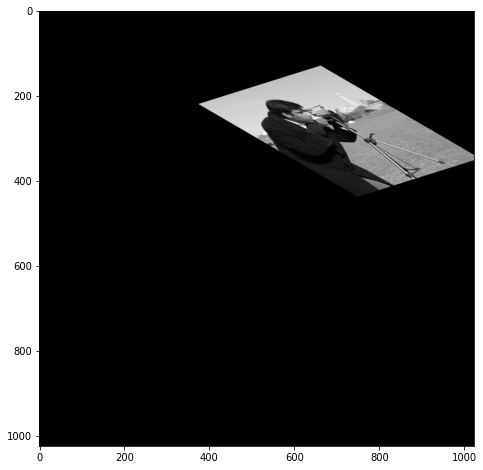

In [50]:
def homogeneous_matrix(theta: float = 0, translation: List[int] = [0, 0], scale: List[float] = [1.0, 1.0], shear: float = 0):
    return np.array([
        [np.cos(theta) / scale[0], -np.sin(theta + shear) / scale[1], translation[0]],
        [np.sin(theta) / scale[0], np.cos(theta + shear) / scale[1], translation[1]],
        [0, 0, 1]
    ])

print(homogeneous_matrix(theta=np.pi/8, translation=np.array([256, -256]), scale=[0.8, 0.4], shear=np.pi/6))

plot_grayscale(skimage.transform.warp(camera_image_background, homogeneous_matrix(theta=np.pi/8, translation=np.array([256, -256]), scale=[0.8, 0.4], shear=np.pi/6)))

> 4. You can check your transformation matrix by using the [skimage.transform.AffineTransform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.AffineTransform) function, using the rotation angle, translation vector and scale (not the inverse). Compute and display the transformation matrix, in homogeneous coordinates, using the arguments specified in step 1 of this exercise.

In [49]:
skimage.transform.AffineTransform(scale=[1/0.8, 1/0.4], rotation=np.pi/8, translation=[256,-256], shear=np.pi/6)

<AffineTransform(matrix=
    [[   1.15484942,   -1.98338335,  256.        ],
     [   0.47835429,    1.52190357, -256.        ],
     [   0.        ,    0.        ,    1.        ]]) at 0x7f263af78f10>

> In one or two sentences answer the following questions. 
> 1. Compare the image size and shape against the original image size. Does the transform appear to be correctly applied and why?   
> 2. Is the homogeneous transformation matrix you computed identical to the one computed with the `AffineTransform` function? 
> **End of exercise.**

> **Answer:** 
> 1. Yes, the image is rotated, translated, scaled, with the addition of shear where the image becomes "slanted".
> 2. Yes, it is identical.

## Working with the Intrinsic Matrix

Up until now, you have been working only with the extrinsic matrix, which defines the projection of an object on the image plane. These transformations do not account for camera parameters.   

The intrinsic matrix is used to model camera characteristics. Here we will only deal with one camera parameter, the focal length. Focal length is typically denoted $[\phi_x, \phi_y]$, for the x and y components, which can be independent.

THe matrix product of the intrinsic matrix and extrinsic matrix is the complete transformation. A transformation accounting for both the relationship between the object and the image plane and the camera characteristics.   

> **Exercise 8-4:** You will now apply an intrinsic matrix for two different camera focal lengths by the following steps:  
> 1. Define a Numpy extrinsic transform matrix in homogeneous coordinates with rotation $= 0$, translation $[-512,-512]$, no scaling, and no shear.  
> 2. Define an intrinsic matrix in homogeneous coordinates with focal length $=2.0$, array offset of 0, and skew correction of 0.  
> 3. Perform matrix multiplication between the transform matrix by the intrinsic matrix using [numpy.matmul](https://numpy.org/de/stable/reference/generated/numpy.matmul.html).
> 4. Print the resulting product of the transformation matrix. 
> 5. Apply the resulting transformation product to the image and display the result. 

[[   2.    0. -512.]
 [   0.    2. -512.]
 [   0.    0.    1.]]


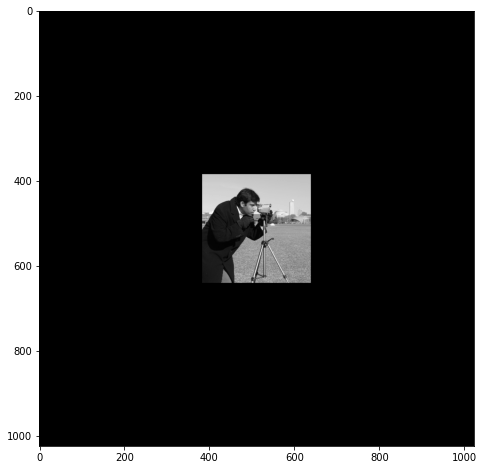

In [56]:
extrinsic = homogeneous_matrix(theta=0, translation=np.array([-512, -512]))

def intrinsic_matrix(focal_length: float = 1.0, offset: int = 0, skew: int = 0):
    return np.array([
        [focal_length, 0, 0],
        [skew, focal_length, 0],
        [0, 0, 1]
    ])

transform_matrix = np.matmul(extrinsic, intrinsic_matrix(2.0, 0, 0))
print(transform_matrix)

plot_grayscale(skimage.transform.warp(camera_image_background, transform_matrix))

> 6. Define a Numpy extrinsic transform matrix in homogeneous coordinates with rotation $= 0$, translation $[256,256]$, no scaling, and no shear.  
> 7. Define an intrinsic matrix in homogeneous coordinates with focal length $=0.5$, array offset of 0, and skew correction of 0.  
> 8. Perform matrix multiplication between the transform matrix by the intrinsic matrix using [numpy.matmul](https://numpy.org/de/stable/reference/generated/numpy.matmul.html).
> 9. Print the resulting product of the transformation matrix. 
> 10. Apply the resulting transformation product to the image and display the result. 

[[ 5.00e-01  0.00e+00 -5.12e+02]
 [ 0.00e+00  5.00e-01 -5.12e+02]
 [ 0.00e+00  0.00e+00  1.00e+00]]


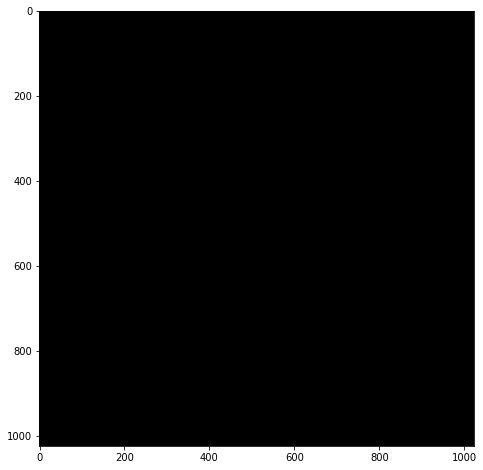

In [63]:
extrinsic = homogeneous_matrix(theta=0, translation=np.array([-512, -512]))

transform_matrix = np.matmul(extrinsic, intrinsic_matrix(0.5, 0, 0))
print(transform_matrix)

plot_grayscale(skimage.transform.warp(camera_image_background, transform_matrix))

> In one or two sentences answer the following questions.  
> 1. Examine the rotation elements of the first complete transformation matrix for focal length of 2.0. What does the diagonal and off diagonal terms tell you about the properties of the resulting transformed image?  
> 2. Examine the first transformed image. Does this image appear as it should and why. 
> 3. Once again examine the rotation elements of the second complete transformation matrix for focal length of 0.5. What does the diagonal and off diagonal terms tell you about the properties of the resulting transformed image?  
> 4. Examine the second transformed image. When compared to the image with focal length of 2.0 is the transformed image with focal length of 0.5 consistent with the change in focal length? 
> **End of exercise**. 

> **Answers:**  
> 1. 
> 2.      
> 3.       
> 4.     

## Projective transform

Projective transforms are the most general planar transformations. Here we will only deal with some simple examples, which are equivalent to changing the camera position. 

We will define the projective transformation matrix as:  

$$
\Omega = 
\begin{bmatrix}
   \omega_{11}  & \omega_{12} & \omega_{13} \\
    \omega_{21}  & \omega_{22} & \omega_{23} \\
    \omega_{31}  & \omega_{32} & \omega_{33}
\end{bmatrix}
$$

To simplify the examples in the exercises, we will not consider any rotation or translation. Thus, $\Omega$ can then be written: 

$$
\Omega = 
\begin{bmatrix}
   1.0  & 0 & 0 \\
    0  & 1.0 & 0 \\
    \omega_{31}  & \omega_{32} & \omega_{33}
\end{bmatrix}
$$

For the following exercise you will work with a picture of a piece of furniture in the interior of a house. To load and prepare this image execute the code in the cell below.  

(3024, 4032, 3)


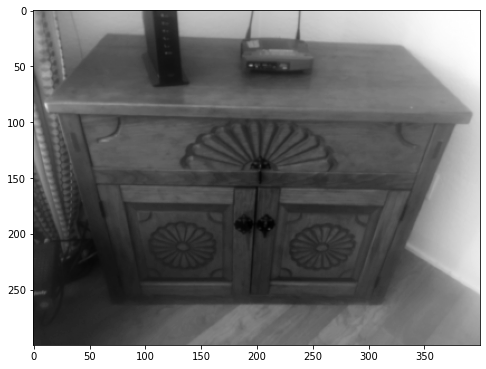

In [59]:
chest = Image.open('../datafiles/Chest.JPG')
chest = np.array(chest)
print(chest.shape)

chest = transform.resize(chest, (300,400))

chest = rgb2gray(chest)
plot_grayscale(chest)

> **Exercise 8-5:** As a first step to get a feel for projective transformations, do the following. 
> 1. Create a Numpy transformation matrix with $[\omega_{31} = 0.002, \omega_{32} = 0.0, \omega_{33} = 0.5]$
> 2. Apply the transformation matrix to the chest image and display the result. 

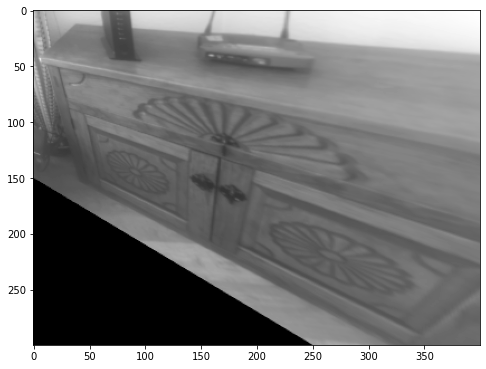

In [60]:
transform_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0.002, 0.0, 0.5]
])

plot_grayscale(skimage.transform.warp(chest, transform_matrix))

> In one or two sentences, how can you qualitatively describe the change in the apparent camera position from this transformation? State your change with respect to the initial camera position. 

> **Answer:** It looks like the camera position rotated to the right, relative to the initial position. The camera is now looking at the chest from roughly a 45 degree angle to the right.

> **Exercise 8-6:** To continue your exploration of the projective transform, do the following. 
> 1. Create a Numpy transformation matrix with $[\omega_{31} = 0.0, \omega_{32} = 0.0025, \omega_{33} = 0.25]$
> 2. Apply the transformation matrix to the chest image and display the result. 

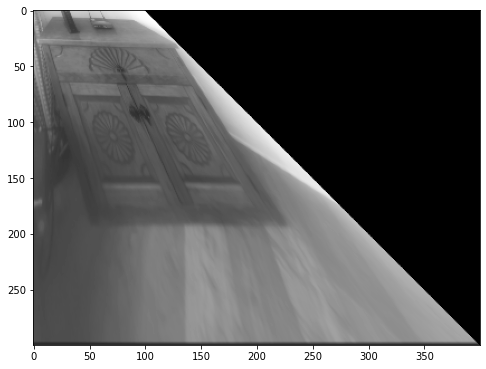

In [61]:
transform_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0.0, 0.0025, 0.25]
])

plot_grayscale(skimage.transform.warp(chest, transform_matrix))

> In one or two sentences, how can you qualitatively describe the change in the apparent camera position from this transformation? State your change with respect to the initial camera position. 

> **Answer:** It looks as if the camera was moved to the back and closer to the floor.

####  Copyright 2022, Stephen F Elston. All rights reserved. 